# TrickTweet
TrickTweet is a Character Language Model which takes in a user's Twitter Handle and generates tweets that sound like them. I chose to use a Character Model over a Language Model for a few reasons:


1.   Character Models take up considerablly less space. For any decent word model to work, it would need to have a large vocabulary and would have to have a size in the order of 1000s. For Character Models, there are < 100 characters that are feasibilly considered. This makes our vocabulary much smaller and lets us consider more samples
2.   Character Models allowed me to consider non english words or words that were not previously encountered. With Word Models, I would be limitted to only words that I had seen in my training data. It would be possible to come up with an "Unknown" token but this would mean that all words that are unknown would have the same meaning and weight by the models definition.



# Imports and Setting up The Path
Here we just do all the imports necessary and set up the Google Colab Path. For reference my path looked like "/content/gdrive/TrickTweet".


You will need to get [Twitter Developer Credentials](https://developer.twitter.com/en/docs) and *change consumer_key*, *consumer_secret*, *access_key*, and access_secret

In [ ]:
import json
import pandas as pd
import numpy as np
import sys
import tweepy
import string
import re
import random
import csv
import os
import matplotlib.pyplot as plt
from pprint import pprint
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, BatchNormalization, Dropout, Bidirectional


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
"""
To get all of these keys, fill out the twitter developer API. Access was granted 
within a day for me
"""
consumer_key = ""
consumer_secret = ""
access_key = ""
access_secret = ""

# Setting up our Parameters
Here we just set up all of our parameters for the model and the preprocessing of the text. 

For reference, the meaning of each parameter is below:
 

* **SEQ_LEN:** The Length of an input sequence in our LSTM. Typically you would want to do 150-250 characters for Tweets so you can get context of surronding tweets.
* **SEQ_STEP:** How much the starting point of your sequence moves at each iteration. If the Sequence Steps is small that means you will have many more samples 
* **PERCENT_VALIDATION:** The percent of data that we will set aside to check validation accuracy 
* **NOISE_VALS:** Used to generate some noise to make sure the same character isn't predicted given the same sequence. If we didn't have noise we'd end up having "the the the....."
* **GEN_LEN:** The length of a generated sequence
* **BATCH_SIZE:** Size of the Batch for our Model 
* **EPOCHS:** How many Epochs we run
* **BASEMODEL_NAME:** Name of the generic Base Model
* **TRAIN_BASE_MODEL:** Make True if you want to train the Base Model instead of a specific user 
* **USE_BASE_MODEL:** Make True if you want to make the Base Model more specific by training for a specific user
* **USE_OLD_MODEL:** Make True if you want to train on top of a model for the same user that is being inputted  
* **ALPHABET** The set of characters that we consider in our tweets. Any character not in this set will be ignored
* **TWITTER_HANDLE:** The handle of the Twitter user that we are looking for the tweets of. 

Note that if you want to train onn an old model, the SEQ_LEN and ALPHABET need to be the same. If they aren't they won't have the same shape and the model will error out. If a user doesn't have a lot of tweets of you want to do less epochs, make USE_BASE_MODEL true. If you want to make an older model more accurate, make USE_OLD_MODEL true. Can change SEQ_STEP-- good if you have less data



In [ ]:
#If getting out of memory errors increase SEQ_LEN
SEQ_LEN = 120
#If getting out of memory errors increase SEQ_STEP
SEQ_STEP = 5
PERCENT_VALIDATION = 0.2
NOISE_VALS = [0.05, 0.1, 0.2,.3,.4,.5,.6,.7, .8,.9]
GEN_LEN = 250
BATCH_SIZE = 64
EPOCHS = 10

BASEMODEL_NAME= "basemodel"

TRAIN_BASE_MODEL = False
USE_BASE_MODEL = False
USE_OLD_MODEL = False 
ALPHABET = set(string.ascii_letters + string.punctuation + ' ')

#Whatever your path is to your root directory containing the Language Model Folder 
MY_DRIVE = "gdrive/My Drive/"
root_folder = os.path.join(MY_DRIVE, "TrickTweet")
models_dir = os.path.join(root_folder, "Models")
weights_dir = os.path.join(root_folder, "Weights")
base_tweets_dir = os.path.join(root_folder, "GenericTweets")

TWITTER_HANDLE= "RBReich"

if TRAIN_BASE_MODEL:
  BASENAME = BASEMODEL_NAME
else:
  BASENAME = TWITTER_HANDLE

# Retrieval of Data
In *get_tweets*, we grab approximitely 3000 tweets from the user (Twitter limits how many tweets that someone can get which makes for this cutoff). Additionally, we can only grab a certain amount of tweets with any 1 call so we loop and call it, each time updating the "start date" of when we want to consider. When putting the tweets into our data frame, we choose to ignore any tweets that the user only retweeted because they don't add any language of their own to it.

In [ ]:
def get_tweets(screen_name):
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_key, access_secret)
    api = tweepy.API(auth)
    alltweets = []  
    new_tweets = api.user_timeline(screen_name = screen_name,count=400)
    alltweets.extend(new_tweets)
    oldest = alltweets[-1].id - 1
    #keep grabbing tweets until there are no tweets left to grab
    i = 0 
    while len(new_tweets) > 0:
        new_tweets = api.user_timeline(screen_name = screen_name,count=400,max_id=oldest)
        alltweets.extend(new_tweets)
        oldest = alltweets[-1].id - 1
        if len(new_tweets) == 0:
          i+=1 
    #transform the tweepy tweets into a 2D array that will populate the df 
    ids = []
    dates = []
    content = []
    outtweets = []
    for tweet in alltweets:
      #Do not want to consider tweets which are retweets with no added content
      if tweet.retweeted:
        continue
      ids.append(tweet.id_str)
      dates.append(tweet.created_at)
      content.append(tweet.text)
      outtweets.append([tweet.id_str, tweet.created_at, tweet.text])
    df = pd.DataFrame({
      "id":ids,
      "dates":dates, 
      "content":content
    })
    return df


In [ ]:
df = get_tweets(TWITTER_HANDLE)
len(df)

3240

# Preprocessing the Data: Cleaning 
Here I cleaned the tweets to ensure that I wasn't taking in tokens that are out of our vocabulary or that have low chance of conveying any useful information. In particular I made the following changes.


1. Removing all links 
2. Removing all mentions to other Twitter users
3. Lowercasing the input


Any tweets that are left empty after the preprocessing are not considered in our data

In [ ]:
def clean_tweets(data):
  lst = []
  for item in data:
    #Removing all links
    newitem = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', item, flags=re.MULTILINE)
    #Remove all mentions to other users 
    newitem = re.sub("@[A-Za-z0-9_]+","",newitem,re.MULTILINE)
    #Lowercase the input
    newitem = "".join([c for c in newitem if c in ALPHABET]).lower()
    #Make sure we aren't just adding an empty tweet
    if newitem and newitem != " ":
      lst.append(newitem)
  return lst 

In [ ]:
if TRAIN_BASE_MODEL:
  data = []
  for file in os.listdir(base_tweets_dir):
    print(file)
    """
    If you want a better performing base model consider splitting the training
    data into small chunks and then making the Step Size really small
    """
    data.extend(clean_tweets(list(pd.read_csv(os.path.join(base_tweets_dir,file)).keys())))
else:
  data = clean_tweets(df["content"])
len(data)

3184

# Preprocessing the Data: Making a Corpus
Here I joined all the tweets and made them into a corpus. It made sense to make them into a corpus rather than consider them as individual items because frequently when someone tweets, they tweeted something relevant prior. 


I also created the mapping of the character to an index for the encoding later on as well as a reverse mapping from the index to the character.

In [ ]:
corpus = ''.join(data)
characters= sorted(list(set(ALPHABET)))
index_to_char = {}
char_to_index = {}
for idx, char in enumerate(characters):
  index_to_char[idx] = char
  char_to_index[char] = idx

# Preprocessing the Data: Making the Input
Here I created all the input sequences of length SEQ_LEN along with the output characters after each sequence. The ith index of output_chars corresponds to the character that follows the ith sequence in input_seqs. 


After this, I converted the input_seqs list into the proper input for the LSTM. It took the dimensions of length of input sequences x length of sequence x size of vocabulary. 

X[i][j][k] refers to the ith sequence, jth index in the sequence, and the kth character where k is the mapping of the jth character to an index

In [ ]:
input_seqs = []
output_chars = []
for i in range(0,len(corpus)-SEQ_LEN, SEQ_STEP):
  input_seqs.append(corpus[i:i+SEQ_LEN])
  output_chars.append(corpus[i+SEQ_LEN])

In [ ]:
X = np.zeros((len(input_seqs), SEQ_LEN, len(characters)))
y = np.zeros((len(output_chars), len(characters)))
for i, seq in enumerate(input_seqs):
  for j, char in enumerate(input_seqs[i]):
    X[i, j, char_to_index[char]] = 1
  y[i, char_to_index[output_chars[i]]] = 1


# Split the Data
Here I split the data and labels into a training set and a label set

In [ ]:
idxes = np.random.permutation(X.shape[0])
val_num = int(PERCENT_VALIDATION*len(X))
X = X[idxes]
X_train = X[val_num:]
X_val = X[:val_num]
y = y[idxes]
y_train = y[val_num:]
y_val = y[:val_num]

# Creating the Model
I used a model with 4 Bidirectional LSTM Layers with Batchnormalization and Drop outs to ensure that we aren't overfitting and that our numbers remaian normalized and don't get too small or too big. I used softmax activation, categorical cross entropy as the loss, and RMSprop as the optimizer.


I also created a couple of helper methods to save and load the models which is useful for training a model on top of another.

In [ ]:
def build_model(num_chars):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, input_shape=(SEQ_LEN, num_chars), return_sequences=True,unit_forget_bias=True)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=.1))
    model.add(Bidirectional(LSTM(128,return_sequences=True,unit_forget_bias=True)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=.1))
    model.add(Bidirectional(LSTM(256,return_sequences=True,unit_forget_bias=True)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=.1))
    model.add(Bidirectional(LSTM(128)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=.2))
    model.add(Dense(num_chars, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='RMSprop')
    
    return model

In [ ]:
def load_keras_model(basename):
    """
        Loads the given model from disk. The model consists of two files, the model definition,
        saved in json, and the model weights, saved in HDF5.
    """
    model = load_model(os.path.join(models_dir, basename))
    model.load_weights(os.path.join(weights_dir, basename))
    return model


def save_keras_model(model, basename):
    """
        Saves the given model to disk, using a generated filename if one is not given.
    """
    model.save(os.path.join(models_dir, basename))
    model.save_weights(os.path.join(weights_dir, basename))

In [ ]:
if USE_OLD_MODEL:
  print("Using Old Model")
  model = load_keras_model(BASENAME)
elif USE_BASE_MODEL:
  print("Using Base Model")
  model=load_keras_model(BASEMODEL_NAME)
else:
  print("Making New Model")
  model = build_model(len(characters))

Making New Model


In [ ]:
trained_model = model.fit(X, y, batch_size=BATCH_SIZE, epochs= EPOCHS, validation_data=(X_val, y_val))

Epoch 1/10
1065/1065 [==============================] - 95s 89ms/step - loss: 2.7289 - val_loss: 2.1587
Epoch 2/10
1065/1065 [==============================] - 92s 86ms/step - loss: 2.0457 - val_loss: 1.9065
Epoch 3/10
1065/1065 [==============================] - 92s 86ms/step - loss: 1.8607 - val_loss: 1.7470
Epoch 4/10
1065/1065 [==============================] - 92s 86ms/step - loss: 1.7363 - val_loss: 1.5925
Epoch 5/10
1065/1065 [==============================] - 92s 86ms/step - loss: 1.6520 - val_loss: 1.5468
Epoch 6/10
1065/1065 [==============================] - 92s 86ms/step - loss: 1.5785 - val_loss: 1.4000
Epoch 7/10
1065/1065 [==============================] - 92s 86ms/step - loss: 1.5095 - val_loss: 1.3151
Epoch 8/10
1065/1065 [==============================] - 92s 86ms/step - loss: 1.4521 - val_loss: 1.2410
Epoch 9/10
1065/1065 [==============================] - 92s 86ms/step - loss: 1.3937 - val_loss: 1.1612
Epoch 10/10
1065/1065 [==============================] - 92s 86m

# Loss
Below is the Training Loss and Validation Loss respectively as we progress through the epochs. Below are the visualizations of the loss

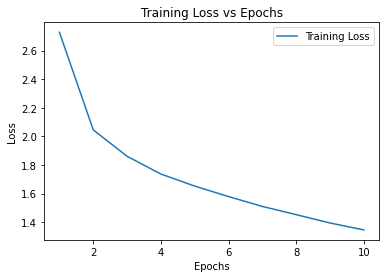

In [ ]:
loss_values = trained_model.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training Loss vs Epochs")
plt.legend()

plt.show()

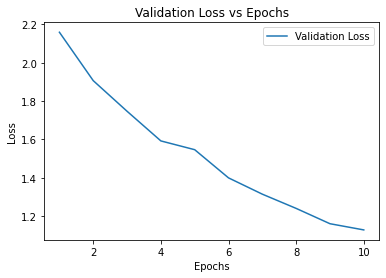

In [ ]:
loss_values = trained_model.history['val_loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Validation Loss vs Epochs")
plt.legend()

plt.show()

# Generating Tweets 
I generated the tweets over here. Within my function, I included an optional seed. Seed is an input phrase and model will predict what comes after it and some random sequence from the corpus. If you do not input a seed it will just start off with a random sequence. Either way, seed is exactly SEQ_LEN characters long.


At each step of the generation, the model will the the current seed as the input and predict the most likely character. This character gets added to our ongoing sequence as well as the current "seed". The first character of the seed gets removed as well. At any point in time, the seed is exactly SEQ_LEN characters long.


The way I predicted what character would come after a function requried some randomness which was found from the NOISE_VALS array. Normally, the largest probability would be the character predicted; however, if this happens that means that it would be really easy to get into a cycle of words "the the the the....". With the noise, we still pick likely words just not the most likely words at all times.




In [ ]:
def sample_predictions(preds, noise=1.0):
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / noise
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  # Return the index of the largest element
  return np.argmax(probas)

def generate_tweet(model = model,corpus = corpus, 
                   char_to_indices = char_to_index, 
                   indices_to_char =index_to_char , 
                   num_chars = len(characters), seed = None):
  g = []
  if not seed:
    rand_num = random.randint(0, len(corpus) - SEQ_LEN - 1)
    seed = corpus[rand_num:rand_num+SEQ_LEN]
    print(seed)
  else:
    rand_num = random.randint(0, len(corpus) - SEQ_LEN-1)
    seed = corpus[rand_num:rand_num+SEQ_LEN-len(seed)] + seed 
  
  for noise in NOISE_VALS:
      generated = ''
      for i in range(GEN_LEN):
          X_pred = np.zeros((1, SEQ_LEN, num_chars))
          for t, c in enumerate(seed):
              X_pred[0, t, char_to_indices[c]] = 1

          predictions = model.predict(X_pred)[0]
          next_index = sample_predictions(predictions, noise)
          next_char = indices_to_char[next_index]
          generated += next_char
          seed = seed[1:] + next_char
      g.append(generated)
  return g

generate_tweet()

 in america.here's what we can do about it: trump is claiming an airplane full of thugs in black uniforms is out to do b


['e make as because the money and republicans who has been all as the pandemic was and percent and budget about the president of the people in when you hear the people of the pandemic was a pandemic reminder that the pandemic reminder that the post of ',
 'the pent of the u.s. the pandemic should be impeachment the pandemic was and percent and the pandemic was as monoly but than the past                                                                                                                     ',
 '                                                                                                                                                                                                                                                          ',
 '                                                                                                                                                                                                                                         

In [ ]:
save_keras_model(model, BASENAME)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: gdrive/My Drive/TrickTweet/Models/RBReich/assets


In [ ]:
!ls "/content/gdrive/My Drive/TrickTweet/Models"

AOC  basemodel	elonmusk  jamescharles	RBReich
